In [1]:
import rasterio as rio
import cufflinks as cf
import numpy as np
import rioxarray as riox
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, Button
from plotly.offline import init_notebook_mode, plot, iplot
from sklearn import preprocessing
import scipy.interpolate as sp
import plotly.express as px
from specutils import Spectrum1D
import astropy.units as u
import numpy as np
import cv2
import os.path
import pysptools.spectro as spectro
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
from sympy import *
import M3spectral.preparation
import M3spectral.plotting
import M3spectral.filtration
import M3spectral.indexes

# Importing data and preparation

In [2]:
#Defining the paths
path_data='/home/jovyan/work/Index/data'
path_results='/home/jovyan/work/Index/results'
target='Valentine2'

In [3]:
#IMPORTANT, DELETE THE TWO FIRST BANDS OF THE IMPUT CUBES AND IMPLEMENT THE CROPPING INSIDE HERE
#Import data: raster and wavelengths
imput_cube=riox.open_rasterio(f'{path_data}/M3_{target}.tif')  #This M3 cube is already proccesed to level 2, hence its values are reflectance and is map projected (see USGS ISIS3)
wavelengths=np.loadtxt(f'{path_data}/Wavelength.txt', delimiter=",")  #This file contains the wavelegnths values of M3, it is neccesary to have it

In [4]:
#This function attach the wavelength to the cube
M3_cube=M3spectral.preparation.attach_wavelen(imput_cube,wavelengths)

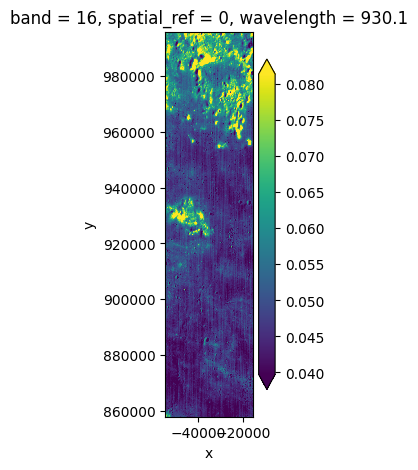

In [5]:
#Viewing the data, arguments are the cube, the band and the size
M3spectral.plotting.cube_plot(M3_cube,15,5)

In [6]:
#Defining the shape of the cube, x=bands, y=horizontal, z=vertical
x,y,z=M3_cube.shape
x,y,z

(83, 1330, 378)

# Smoothing of the Spectra

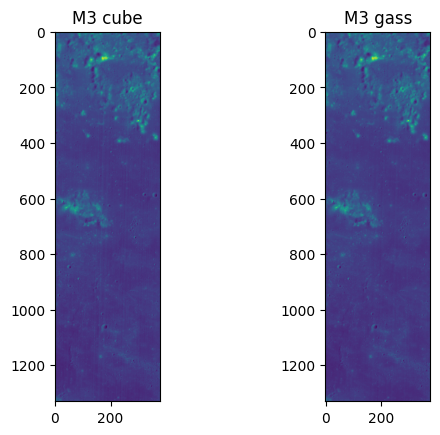

In [7]:
#Doing a gaussian filtration
M3_gauss=M3spectral.filtration.gauss_filter(M3_cube,wavelengths)  #Inputs are the original cube and wavelengths

#Plotting the images to compare
M3spectral.plotting.plot_comparison(M3_cube,M3_gauss, 'M3 cube', 'M3 gass',5) #Inputs are the cubes to compare, their names, and the band

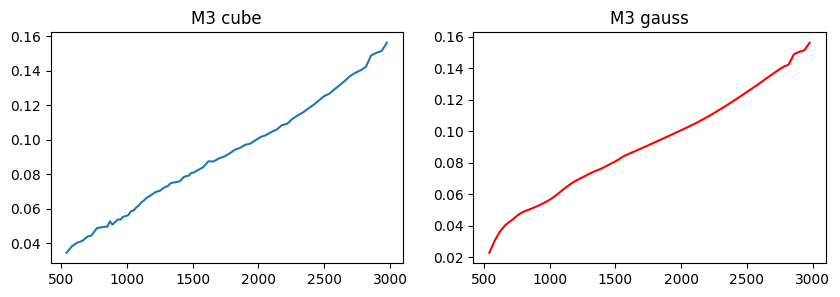

In [8]:
#Comparing a spectral signature before and after the gaussian fitler
M3spectral.plotting.profile_comparison(M3_cube,M3_gauss,wavelengths,'M3 cube','M3 gauss',43,57)  #Inputs are the cubes to compare, wavelengths, their names, and the pixel x and y

/home/jovyan/work/Index/scripts/M3spectral/plotting.py:40: RuntimeWarning:

divide by zero encountered in log



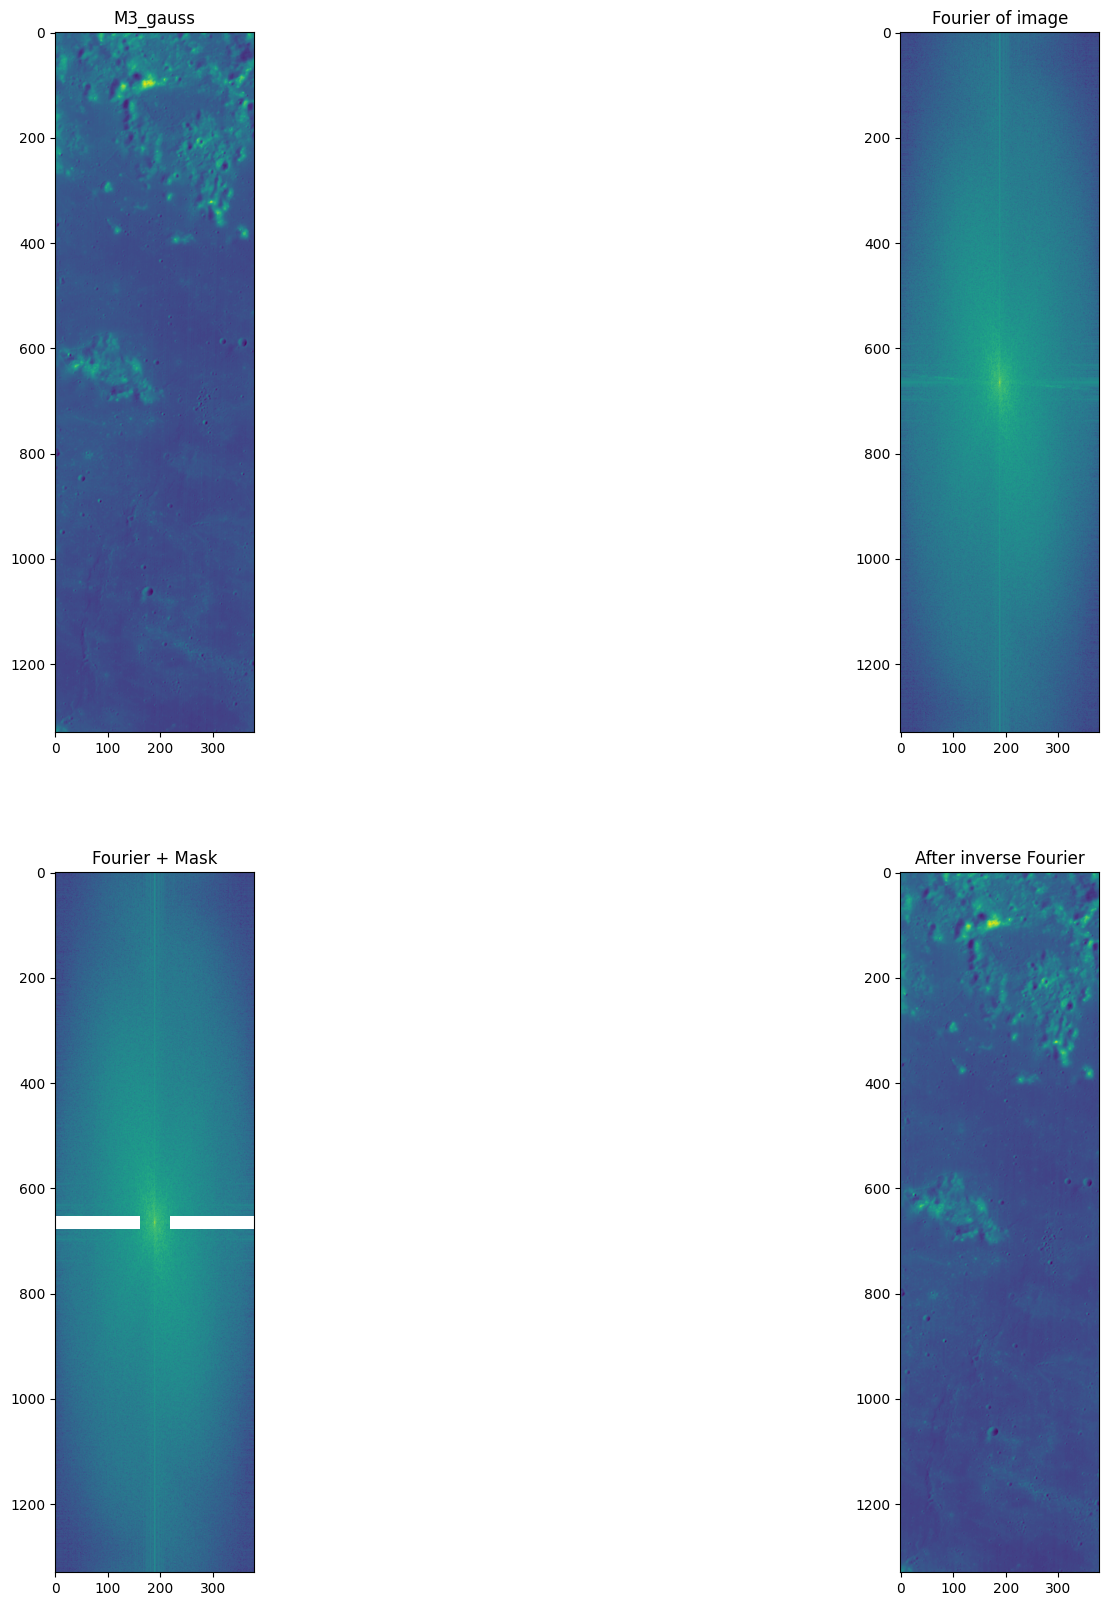

In [9]:
#Doing a fourier filtration
M3_fourier=M3spectral.filtration.fourier_filter(M3_gauss,30,10)  #Inputs are the gaussian filtered cube, and width and altitude of the mask, we recommend 30 and 10

#Plotting to check
M3spectral.plotting.fourier_plot(M3_gauss,M3_fourier,45,30,10)  #Inputs are the gaussian filtered cube, band, and width and altitude of the mask, we recommend 30 and 10

# Extracting data needed to obtain the parameters

In [10]:
#Convex Hull, this is a method to remove the continumm from the spectra, it is a product and also as an imput for some indexes 
M3_hull=M3spectral.preparation.convex_hull(M3_fourier,wavelengths)  #Inputs are te fourie filtered cube and wavelengths

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

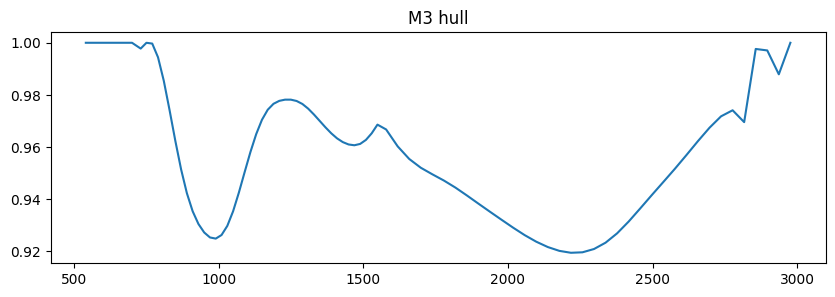

In [11]:
#Convex Hull plot
M3spectral.plotting.profile_plot(M3_hull,wavelengths,'M3 hull',54,879)  #Inputs are the cube, wavelengths, name, and the pixel coordinates

In [12]:
#Exporting the continumm removed cube
M3_hull.rio.to_raster(f'{path_results}/M3_{target}_conremoved.tif') 

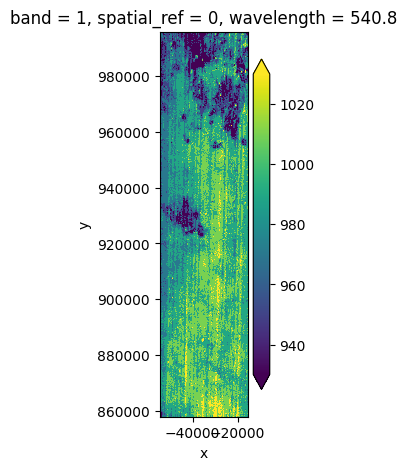

In [13]:
# Making rasters with the wavelength of minimum reflectance in 1000 um and 2000 um respectively
M3_min1000, M3_min2000=M3spectral.preparation.find_minimums(M3_hull,wavelengths)  #Inputs are the convex hull and wavelengths, outputa the two minimums

#Plotting to check
M3spectral.plotting.image_plot(M3_min1000,5)

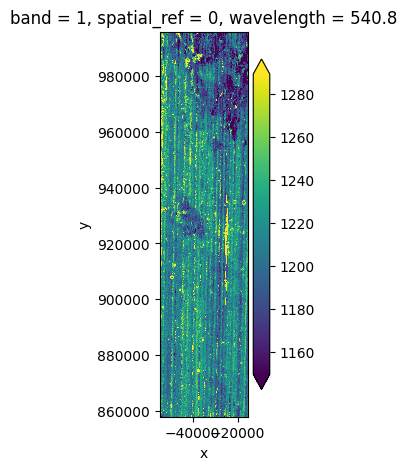

In [14]:
#Obtaining the shoulders, point of maximum reflectance beetween the minimum
M3_shoulder0, M3_shoulder1, M3_shoulder2, M3_shoulder3=M3spectral.preparation.find_shoulders(M3_hull,wavelengths)  #Inputs are the convex hull and wavelengths, outputs the four shoulders

#Plotting to check
M3spectral.plotting.image_plot(M3_shoulder1,5)

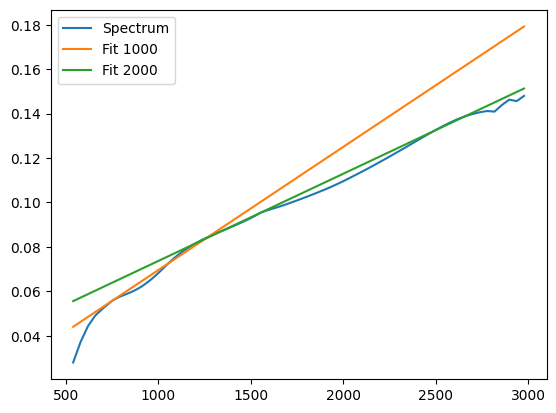

In [15]:
#Continumm functions, these are neccesary to obtain certain parameters
fit_1000=M3spectral.preparation.continnum_1000(M3_fourier.data, M3_hull.data,wavelengths,164,80)  #Input filtered cube, hull, wavelen, x and y pixel coords, output 1000-2000 fits
fit_2000=M3spectral.preparation.continnum_2000(M3_fourier, M3_hull,wavelengths,164,80)

#Plotting the fits to check
M3spectral.plotting.plot_continnums(M3_fourier,fit_1000,fit_2000,wavelengths,164,80)  #Input filtered cube, the 1000 and 2000 fits, wavelengths, and x and y cooridnates for the pixel

# Indexes

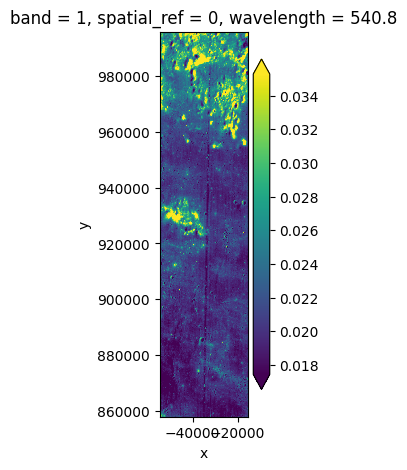

In [16]:
#R540, reflectance at 540 nm
M3_R540=M3spectral.indexes.R540(M3_fourier) #Input filtered cube
M3_R540.rio.to_raster(f'{path_results}/M3_{target}_R540.tif')
M3spectral.plotting.image_plot(M3_R540,5)

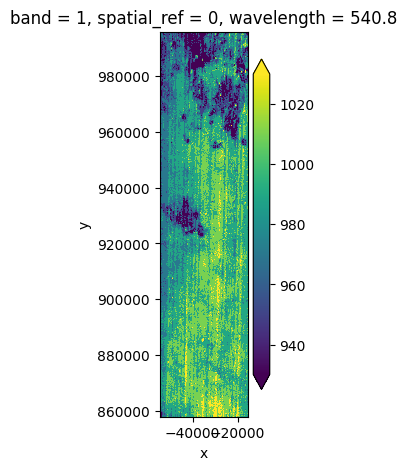

In [17]:
#BCI, Band minimum at 1000, location of the minimum point after continuum removal, calculated before
M3_min1000.rio.to_raster(f'{path_results}/M3_{target}_BCI.tif')
M3spectral.plotting.image_plot(M3_min1000,5)

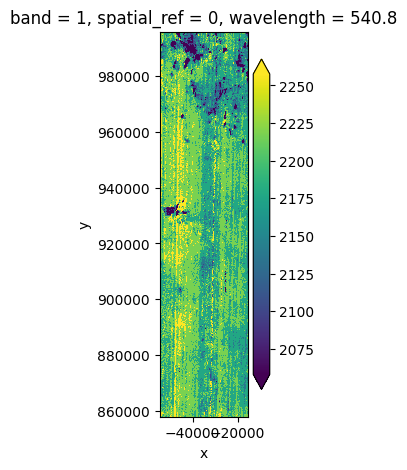

In [18]:
#BCII, Band minimum at 2000, location of the minimum point after continuum removal,calculated before 
M3_min2000.rio.to_raster(f'{path_results}/M3_{target}_BCII.tif')
M3spectral.plotting.image_plot(M3_min2000,5)

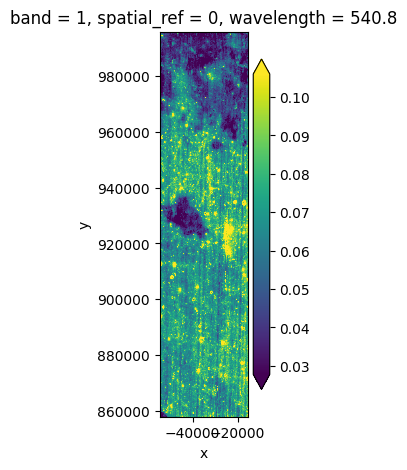

In [19]:
#BDI, band depth at 1000 nm, it is obtained by dividing the reflectance by the value of the continnum at that location, always positive
M3_BDI=M3spectral.indexes.BDI(M3_fourier,M3_hull,wavelengths)  #Inputs fitlered cube, hull and wavelengths, outputs the BDI
M3_BDI.rio.to_raster(f'{path_results}/M3_{target}_BDI.tif')
M3spectral.plotting.image_plot(M3_BDI,5)

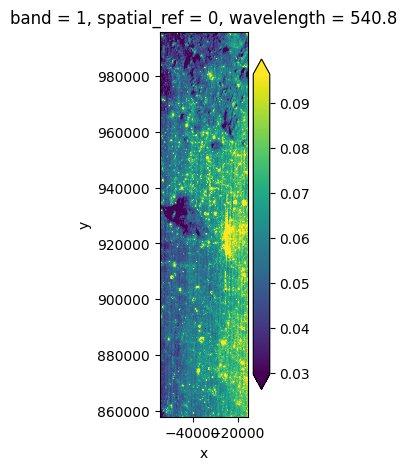

In [20]:
#BDII, band depth at 2000 nm, it is obtained by dividing the reflectance by the value of the continnum at that location, always positive
M3_BDII=M3spectral.indexes.BDII(M3_fourier,M3_hull,wavelengths)  #Inputs fitlered cube, hull and wavelengths, outputs the BDI
M3_BDII.rio.to_raster(f'{path_results}/M3_{target}_BDII.tif')
M3spectral.plotting.image_plot(M3_BDII,5)

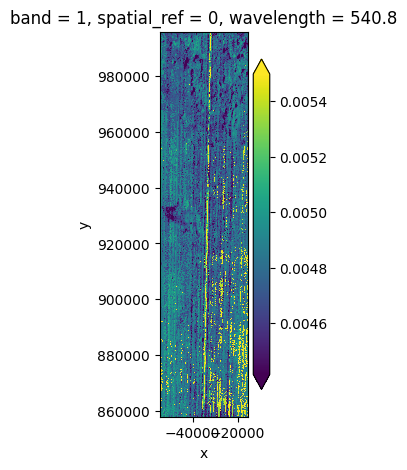

In [21]:
#SS1200, Spectral slope between maximun right shoulder and 540nm
M3_SSI=M3spectral.indexes.SSI(M3_fourier, M3_hull,wavelengths) #Inputs are filtered cube, hull and wavelengths
M3_SSI.rio.to_raster(f'{path_results}/M3_{target}_SSI.tif')
M3spectral.plotting.image_plot(M3_SSI,5)

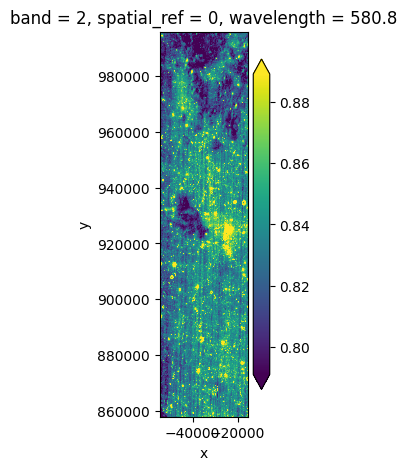

In [22]:
#Clementine-like RGB. R: R750 nm/R540 nm, G:,R750 nm/R1000 nm, B:R540nm/R750 nm
M3_clem=M3spectral.indexes.clementine(M3_fourier) #Inputs filtered cube
M3_clem.rio.to_raster(f'{path_results}/M3_{target}_CLEM.tif')
M3spectral.plotting.cube_plot(M3_clem,1,5)

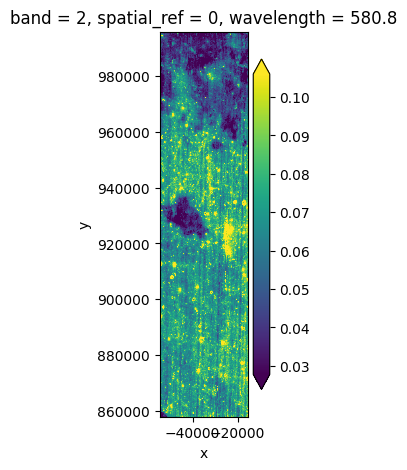

In [23]:
#RGB1. R: SSI, G: BDI, B: BDII
M3_RGB1=M3spectral.indexes.RGB1(M3_fourier,M3_SSI,M3_BDI,M3_BDII) #Inputs filtered cube, SSI, BDI, BDII
M3_RGB1.rio.to_raster(f'{path_results}/M3_{target}_RGB1.tif')
M3spectral.plotting.cube_plot(M3_RGB1,1,5)

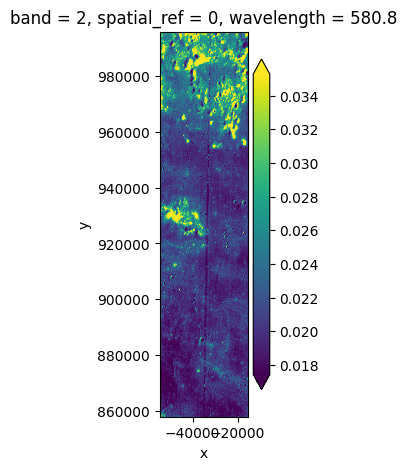

In [24]:
#RGB2. R: SSBI, G: R540 nm, B: BCII
M3_RGB2=M3spectral.indexes.RGB2(M3_fourier, M3_SSI, M3_R540, M3_min2000)  #Inputs filtered cube, SSI, R540, BCII
M3_=M3_RGB2.rio.to_raster(f'{path_results}/M3_{target}_RGB2.tif')
M3spectral.plotting.cube_plot(M3_RGB2,1,5)

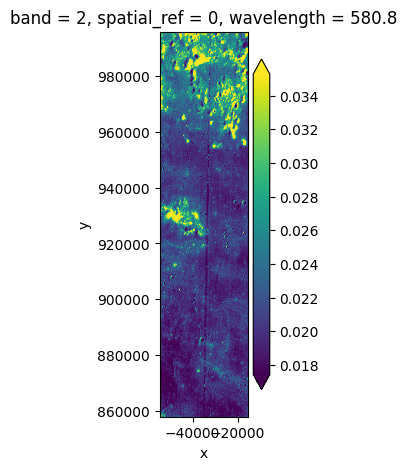

In [25]:
#RGB3. R: SSBI, G: R540 nm, B: BCI
M3_RGB3=M3spectral.indexes.RGB3(M3_fourier,M3_SSI, M3_R540,M3_min1000) #Inputs filtered cube, SSI, R540, BCI
M3_RGB3.rio.to_raster(f'{path_results}/M3_{target}_RGB3.tif')
M3spectral.plotting.cube_plot(M3_RGB3,1,5)

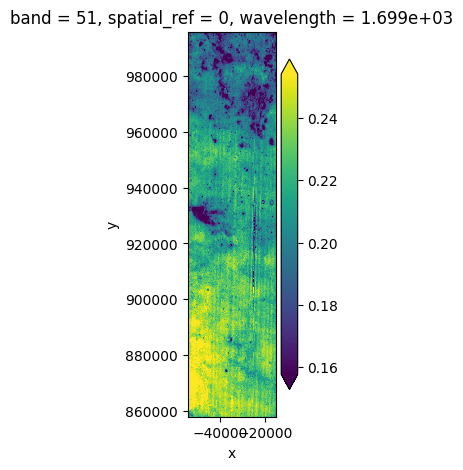

In [26]:
#Olivine detection index
M3_ol=M3spectral.indexes.olivine(M3_fourier)  #Input filtered cube
M3_ol.rio.to_raster(f'{path_results}/M3_{target}_Ol.tif')
M3spectral.plotting.image_plot(M3_ol,5)

#NIR Color 1, R: BD 1900, IBD 2000, IBD 1000
#Band 1
NIRB1=(1 - (M3_Foufilter[55,:,:]/((M3_Foufilter[70,:,:]-M3_Foufilter[39,:,:]/2498-1408)*((1898-1408)+M3_Foufilter[39,:,:]))))

#Band 2
NIRB2=M3_Foufilter[0,:,:].copy()
M3_Slice1=M3_Foufilter[49:70,:,:]
stack12=[]
for a in range(M3_Slice1.data.shape[1]):
    for b in range(M3_Slice1.data.shape[2]):
        for c in range(M3_Slice1.data.shape[0]):
            sum1=0
            imput_nir=M3_Foufilter.data[c,a,b]
            imput_hull3=M3_Hull.data[:,a,b]
            
            mgmwh23=np.where(imput_hull3[40:66] == max(imput_hull3[40:66]))[0][-1]+40
            mgmwh2y3=imput_BDII[mgmwh23]
            mgmwh2x3=wavelengths[mgmwh23]
            mgmwh33=np.where(imput_hull3[66:83] == max(imput_hull3[66:83]))[0][0]+66
            mgmwh3y3=imput_BDII[mgmwh33]
            mgmwh3x3=wavelengths[mgmwh33]
            mgmxw20003=np.array(mgmwh2x3)
            mgmxw20003=np.append(mgmxw20003,mgmwh3x3)
            mgmyw20003=np.array(mgmwh2y3)
            mgmyw20003=np.append(mgmyw20003,mgmwh3y3)
            fitw20003=np.polyfit(mgmxw20003,mgmyw20003,1)
            fitnir_2000=np.polyval(fitw20003, wavelengths[c])
            
            sum1 += (1-(imput_nir/fitnir_2000))
            stack12.append(sum1)
        
stack12a=np.array(stack12)
NIRB2.data=stack12a.reshape(y,z)

#Band 3
NIRB3=M3_Foufilter[0,:,:].copy()
M3_Slice2=M3_Foufilter[8:34,:,:]
stack13=[]
for a in range(M3_Slice2.data.shape[1]):
    for b in range(M3_Slice2.data.shape[2]):
        for c in range(M3_Slice2.data.shape[0]):
        
            sum2=0
            imput_nir2=M3_Foufilter.data[c,a,b]
            imput_hull4=M3_Hull.data[:,a,b]
            
            mgmwh012=np.where(imput_hull4[0:20] == max(imput_hull4[0:20]))[0][-1]
            mgmwh0y12=imput_BDI[mgmwh012]
            mgmwh0x12=wavelengths[mgmwh012]
            mgmwh112=np.where(imput_hull4[20:40] == max(imput_hull4[20:40]))[0][-1]+20
            mgmwh1y12=imput_BDI[mgmwh112]
            mgmwh1x12=wavelengths[mgmwh112]
            mgmxw100012=np.array(mgmwh0x12)
            mgmxw100012=np.append(mgmxw100012,mgmwh1x12)
            mgmyw100012=np.array(mgmwh0y12)
            mgmyw100012=np.append(mgmyw100012,mgmwh1y12)
            fitw10002=np.polyfit(mgmxw100012,mgmyw100012,1)
            fitnir_1000=np.polyval(fitw10002, wavelengths[c])
            
            sum2 += (1-(imput_nir2/fitnir_1000))
            stack13.append(sum1)
            
stack13a=np.array(stack13)
NIRB3.data=stack13a.reshape(y,z)

#Composite

NIR=M3_Foufilter[0:3,:,:].copy()
NIR.data=np.dstack((NIRB1,NIRB2,NIRB3)).transpose(2,0,1)
NIR.rio.to_raster(f'{path_results}/M3_{target}_NIR.tif')

In [22]:
#CCA R:BCI, G: BCII, B:BAI
#BAI
#Spectral resolution
SR=np.diff(wavelengths)
SR=np.append(39.92,SR)   

#Reflectance beetween shouders
BAI=M3_Foufilter[0,:,:].copy()
stack14=[]
for a in range(M3_Gaussfilter.data.shape[1]):
    for b in range(M3_Gaussfilter.data.shape[2]):
            
            s0 = M3_shoulder0.data[a,b]
            s1 = M3_shoulder1.data[a,b]
        
            start = np.where(wavelengths == s0)[0][0].item()
            end = np.where(wavelengths == s1)[0][0].item()
        
           
            imput_SR= SR[start:end]
            imput_CCA= M3_Foufilter.data[:,a,b]
            
            sum3=0
            for c in range(start, end):
                
                sum3 += ((1 - imput_CCA[c-start]) * imput_SR[c-start])
                
            stack14.append(sum3)
        
stack14a=np.array(stack14)
BAI.data=stack14a.reshape(y,z)
CCA=M3_Foufilter[0:3,:,:].copy()
CCA.data=np.dstack((M3_min1000,M3_min2000,BAI)).transpose(2,0,1)
CCA.rio.to_raster(f'{path_results}/M3_{target}_CCA.tif')

In [65]:
#ACA Band asimetry R:ASY, G:BCII, B: BAI
ASY=M3_Foufilter[0,:,:].copy()

stack15=[]
stack16=[]
for a in range(M3_Gaussfilter.data.shape[1]):
    for b in range(M3_Gaussfilter.data.shape[2]):
            
            s2 = M3_shoulder2.data[a,b]
            s3 = M3_shoulder3.data[a,b]
            min2000=M3_min2000.data[a,b]

            start1 = np.where(wavelengths == s2)[0][0].item()
            end1 = np.where(wavelengths == s3)[0][0].item()
            middle=np.where(wavelengths == min2000)[0][0].item()
           
            imput_SR1= SR[start1:middle]
            imput_SR2= SR[middle:end1]
            imput_CCA= M3_Foufilter.data[:,a,b]
            
            
            sum4=0
            for c in range(start1, middle):
                
                sum4 += ((1 - imput_CCA[c-start1]) * imput_SR1[c-start1])
                
            stack15.append(sum4)
            
            
            sum5=0
            for d in range(middle, end1):
                
                sum5 += ((1 - imput_CCA[d-middle]) * imput_SR2[d-middle])
                
            stack16.append(sum5)         

In [79]:
#Asimetry calculation
total_A=np.add(stack15,stack16)
stack17=[]

for a in range(len(stack16)):
                
    if stack15[a] > stack16[a]:
                    
        stack17.append (-((stack15[a]*100)/total[a]))
                    
    else:
                
        stack17.append(stack16[a]*100/total[a])

stack17a=np.array(stack17)
ASY.data=stack17a.reshape(y,z)
ACA=M3_Foufilter[0:3,:,:].copy()
ACA.data=np.dstack((ASY,M3_min2000,BAI)).transpose(2,0,1)
CCA.rio.to_raster(f'{path_results}/M3_{target}_ACA.tif')

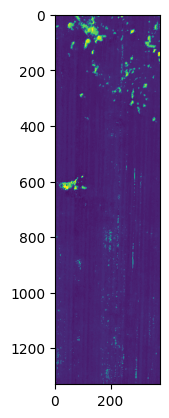

In [77]:
plt.imshow(ASY)

In [69]:
stack15[1]

718.6918415938079

In [70]:
total[1]

1171.6416639279637